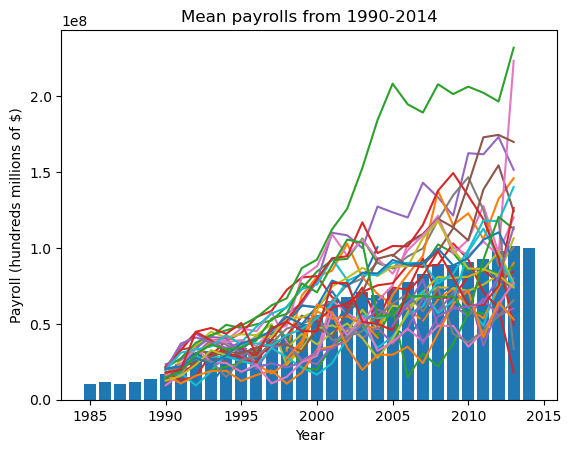

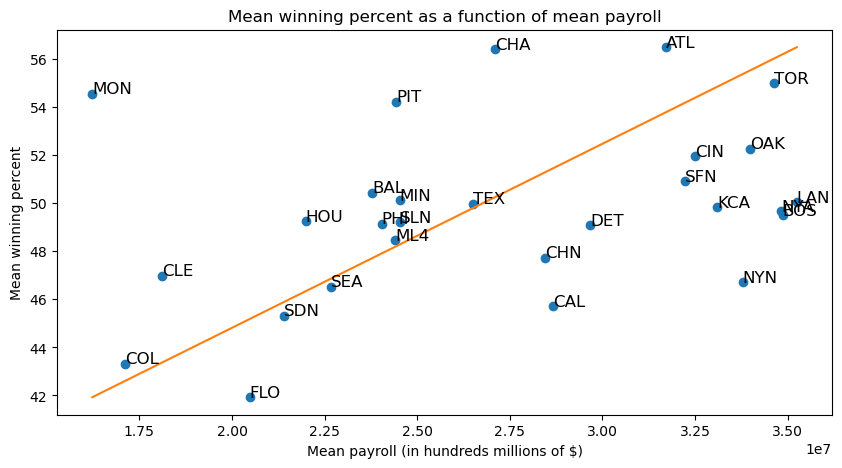

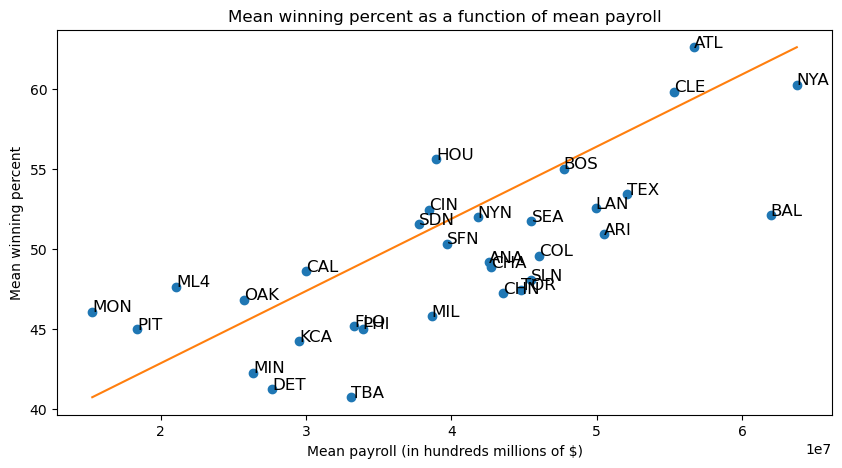

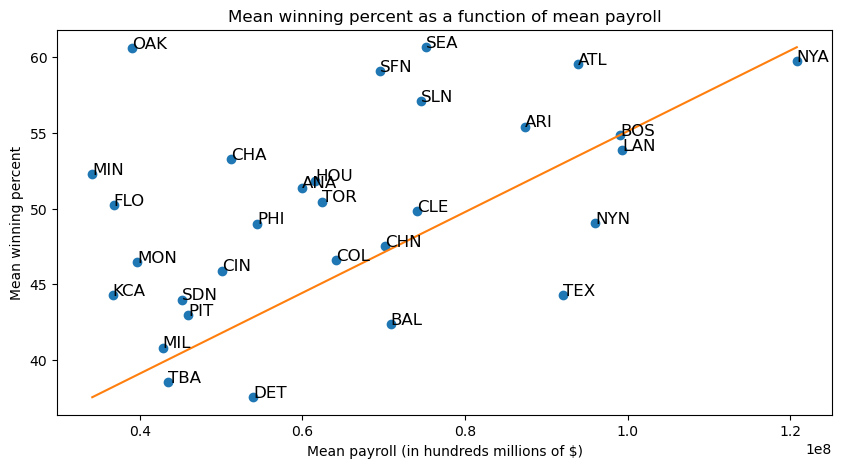

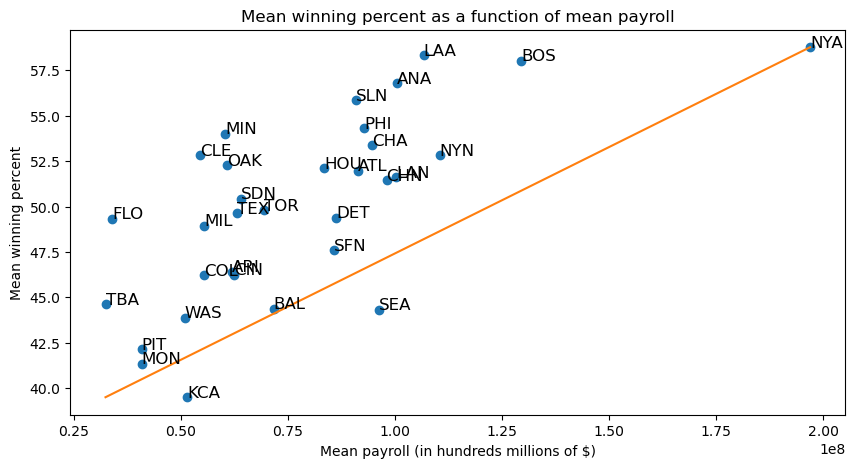

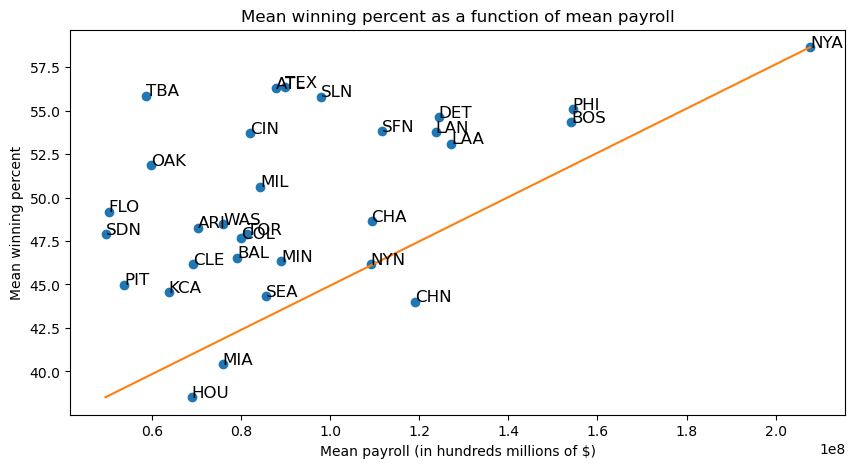

C:\Users\Kevin\AppData\Local\Temp\ipykernel_23384\193095208.py:155: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  payroll['standardized_payroll'][index1] = (payroll['total_payroll'][index1] - pay) / std


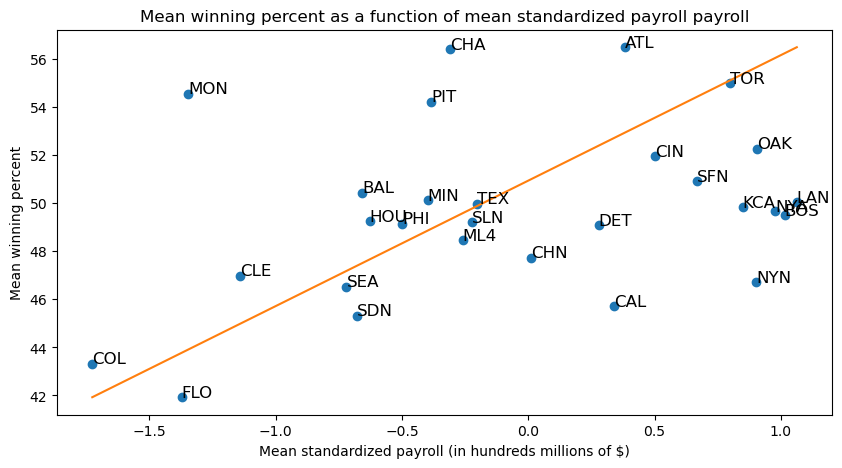

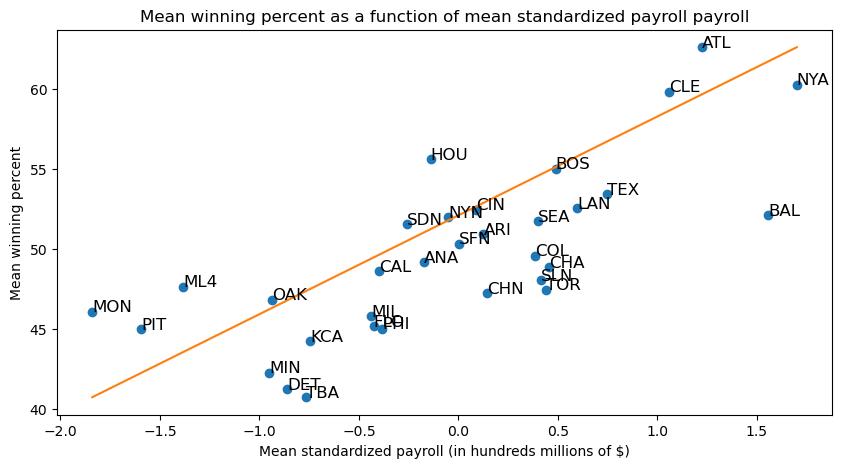

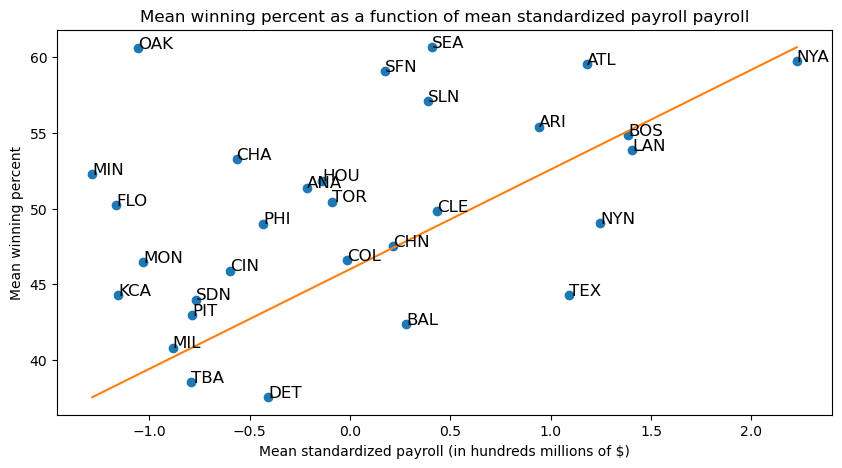

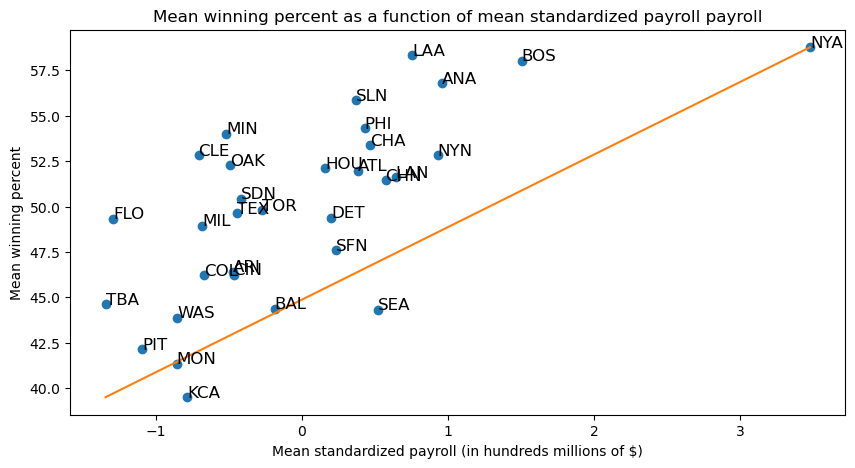

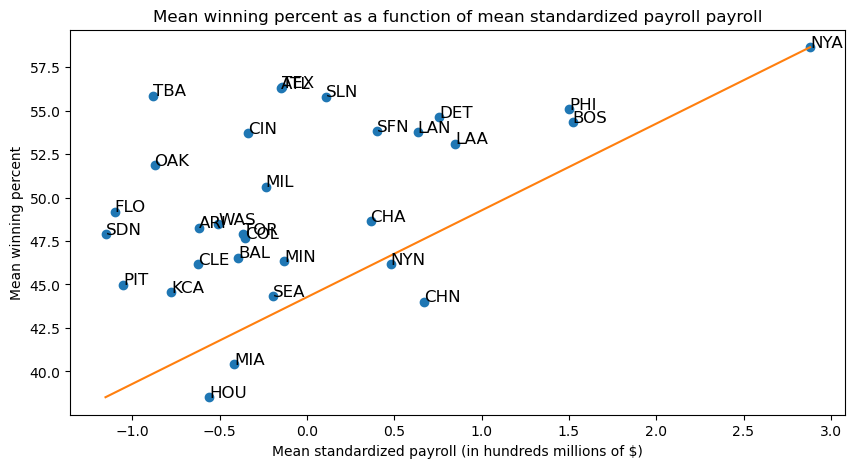

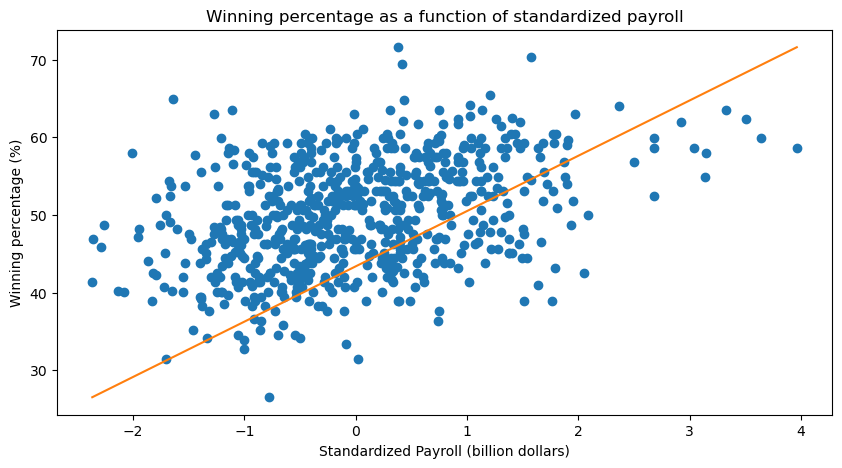

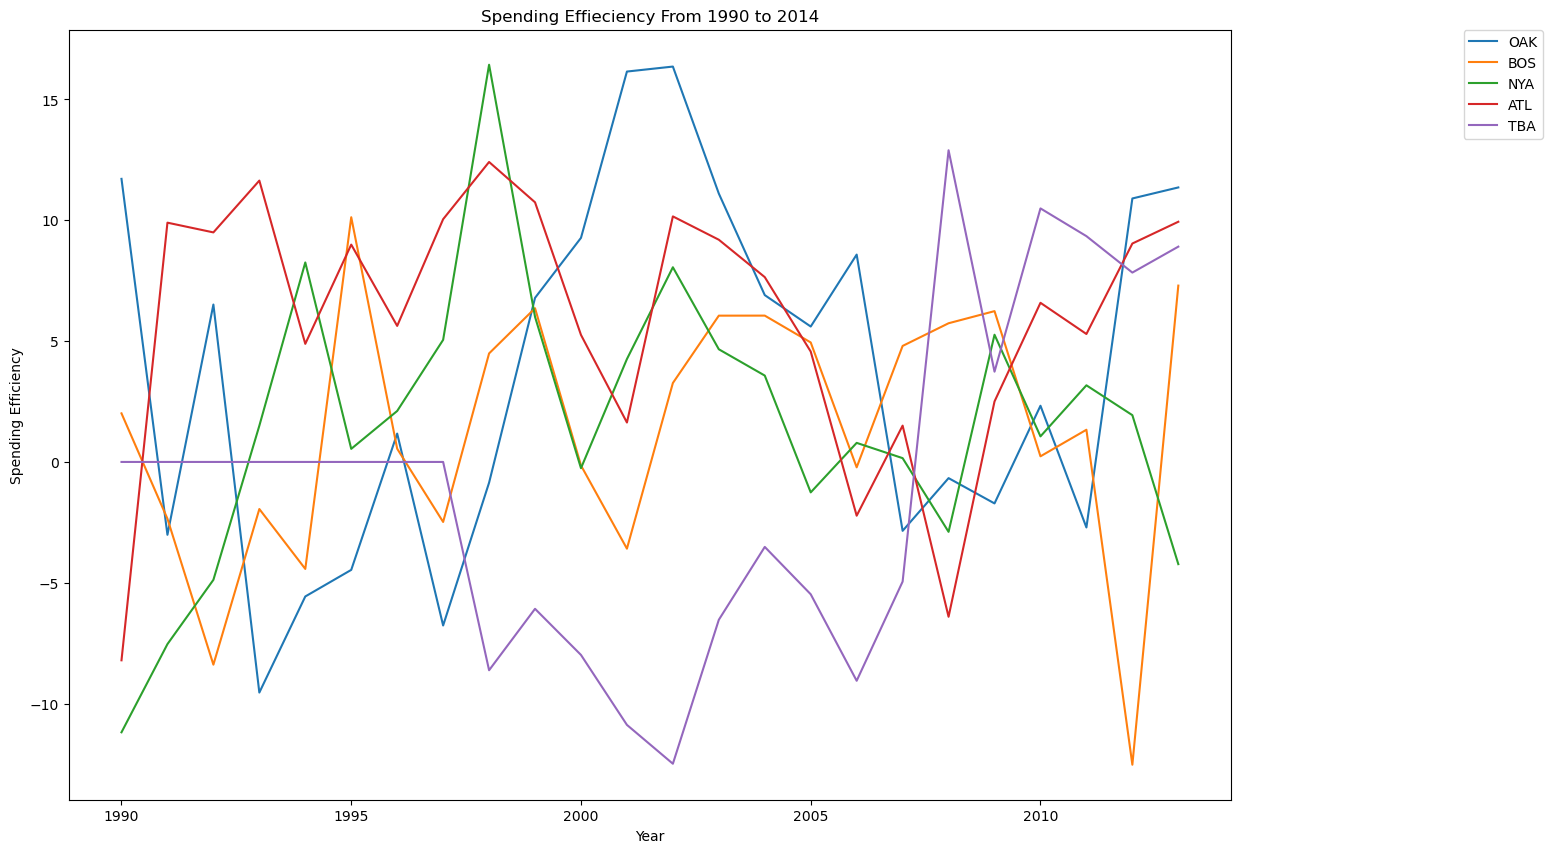

In [27]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Part 1: Wrangling
#Problem 1
#connects to database
sqlite_file = 'lahman2014.sqlite'
conn = sqlite3.connect(sqlite_file)

curr = conn.cursor()
curr.execute("SELECT name FROM sqlite_master WHERE type='table';")
#print(curr.fetchall())

#Salaries query
salaries_query = "SELECT teamID, yearID, sum(salary) as total_payroll FROM Salaries \
GROUP BY teamID, yearID ORDER BY teamID"
salaries_table = pd.read_sql(salaries_query, conn) #creates table
#print(salaries_table)

#Wins query
wins_query = "SELECT teamID, yearID, W as wins, G as games, \
CAST(W AS FLOAT)*100 / (G) as win_percentage, franchID FROM teams \
GROUP BY teamID, yearID ORDER BY teamID"
wins_table = pd.read_sql(wins_query, conn) #creates table
#print(wins_table)

#Merges the 2 tables
merge = salaries_table.merge(wins_table, how = "inner", 
                             left_on = ["teamID", "yearID"], right_on = ["teamID", "yearID"])
#print(merge)

#Part 2: Exploratory Data Analysis
#Problem 2
#gets the teams
teams = np.unique(merge.iloc[:,0].values)
#print(teams)
#creates data for the 1990-2014 time frame
years = np.arange(1990, 2014)
years_table = pd.DataFrame(columns = ['yearID'], data = years)
#print(years_table)
#creates the graph, including title, x, and y axes
plt.title("Payrolls from 1990 to 2014")
plt.xlabel("Year")
plt.ylabel("Payroll (hundreds millions of $)")

data_hash = {} #data in the form of a hash map
for team in teams:
    #gets the data of the current team
    team_data = merge.drop(merge[team != merge['teamID']].index)

    #leaves only the relevant data
    relevant = merge[['yearID','teamID','total_payroll']].groupby('teamID').get_group(team)

    #adds the current team's data to the hashmap
    #plots the data on the graph
    data_hash[team] = years_table.merge(relevant, how = 'inner', left_on = ['yearID'], right_on = ['yearID'])
    plt.plot(data_hash[team]['yearID'], data_hash[team]['total_payroll'].fillna(value = 0))

#Question 1: 
#The trend for payrolls INCREASES over time.
#In addition, over the years, the payroll differences between the teams increase.

#Problem 3
#plots the mean payroll for each year from 1990 to 2014
means = merge[['yearID', 'total_payroll']]
mean_payrolls = (means.groupby('yearID')).mean()
plt.title("Mean payrolls from 1990-2014")
plt.xlabel("Year")
plt.ylabel("Payroll (hundreds millions of $)")
plt.bar(mean_payrolls.index, mean_payrolls['total_payroll'])

#Problem 4
#gets the teams
teams = np.unique(merge.iloc[:,0].values)
#creates data for the 1990-2014 time frame
years = np.arange(1990, 2014)
years_table = pd.DataFrame(columns = ['yearID'], data = years)
#selects columns
data = merge[['yearID', 'teamID', 'total_payroll', 'wins', 'games']]
data = years_table.merge(data, how = "inner", left_on = ['yearID'], right_on = ['yearID'])
#specifies the time frames
time_frames = ['1990-1994', '1995-1999', '2000-2004', '2005-2009', '2010-2014']
data['time_frame'] = pd.cut(data['yearID'], right = False, bins = 5, labels = time_frames)
#print(data)
#makes the graph for each period
for time_frame in time_frames:
    #gets the current time frame's data
    current = data.drop(data[time_frame != data['time_frame']].index)

    #computes the mean winning percentage for each team in that specific time frame
    current['win_rate'] = (100 * current['wins']) / current['games']
    mean_wins = (current.groupby(['teamID']))['win_rate'].mean()

    #computes the mean payroll for each team in that specific time frame
    mean_payrolls = (current.groupby(['teamID']))['total_payroll'].mean()

    #converts mean_wins and mean_payrolls to DataFrames
    wins = mean_wins.to_frame()
    payrolls = mean_payrolls.to_frame()

    #organizes the columns of the new table
    payrolls['teamID'] = payrolls.index
    wins['teamID'] = wins.index
    #avoids teamID in index and column ambiguity error
    wins.reset_index(drop = True, inplace = True)
    payrolls.reset_index(drop = True, inplace = True)
    #merges the 2 tables
    table = payrolls.merge(wins, how = "inner", left_on = ['teamID'], right_on = ['teamID'])
    table.columns = ['mean_payroll', 'teamID', 'mean_winning_percent']

    #graphs the data
    x_axis = table['mean_payroll'].values
    y_axis = table['mean_winning_percent'].values
    fit = np.polyfit(x = x_axis, y = y_axis, deg = 1) #fits the data within a polynomial function
    function = np.poly1d(fit) #defines a polynomial function
    new_x_axis = np.linspace(x_axis.min(), x_axis.max(), 25) #creates new x-axis
    new_y_axis = np.linspace(y_axis.min(), y_axis.max(), 25) #creates new y-axis
    plt.figure(figsize = (10, 5)) #sets the size of the graph
    plt.plot(x_axis, y_axis, 'o', new_x_axis, new_y_axis)
    #specifies the team name for each piece of data
    for index, name in enumerate(table['teamID']):
        plt.annotate(name, (x_axis[index], y_axis[index]), size = 12)
    #names the axes of the graph
    plt.title("Mean winning percent as a function of mean payroll")
    plt.xlabel("Mean payroll (in hundreds millions of $)")
    plt.ylabel("Mean winning percent")
    plt.show()

#Question 2
#The general trend is that the higher the mean payroll, the higher the mean winning percentage.
#One team that stands out as being particularly good at paying for wins is NYA.
#Over time, it seems that Oakland A's spending efficiency is relatively high acros these time periods.

#Problem 5
#gets the average and standard deviation of the payrolls in the data
average_pay = data.groupby(['yearID'])['total_payroll'].mean()
std_pay = data.groupby(['yearID'])['total_payroll'].std()
#converts the objects defined above into DataFrame objects
average_pay = average_pay.to_frame()
std_pay = std_pay.to_frame()
#adds a yearID column to each table
average_pay['yearID'] = average_pay.index
std_pay['yearID'] = std_pay.index
#avoids yearID in index and column ambiguity error
average_pay.reset_index(drop = True, inplace = True)
std_pay.reset_index(drop = True, inplace = True)
#merges the 2 tables
merged_data = average_pay.merge(std_pay, how = 'inner', left_on = ['yearID'], right_on = ['yearID'])
merged_data.columns = ['average_payroll', 'yearID', 'standard_deviation']
#selects relevant columns to calculate the standard payroll
payroll = data[['yearID', 'teamID', 'total_payroll', 'time_frame']].copy() #deep copy
#calculates standard payroll
payroll['standardized_payroll'] = 0.0
for index1, pay_row in payroll.iterrows():
    for index2, std_row in merged_data.iterrows():
        if pay_row['yearID'] == std_row['yearID']:
            #calculates standard payroll for THAT year, adds it to the payroll table
            pay = merged_data['average_payroll'][index2]
            std = merged_data['standard_deviation'][index2]
            payroll['standardized_payroll'][index1] = (payroll['total_payroll'][index1] - pay) / std
#reorganizes the data
payroll.sort_values(by = ['yearID', 'teamID'], inplace = True)
payroll = payroll[['yearID', 'teamID', 'total_payroll', 'standardized_payroll', 'time_frame']]

#Question 3
#Both plots from Problem 4 and Problem 6 show an increasing trend with respect to the payroll variable.
#However, one major difference lies in the x-axes. The x values for Problem 6 contain negative values, 
#while the x values for Problem 4 contain only positive values.

#Problem 6
data['standardized_payroll'] = payroll['standardized_payroll'].values
#makes a graph for each time frame
for time_frame in time_frames:
    #gets the current time frame's data
    current = data.drop(data[time_frame != data['time_frame']].index)

    #computes the mean winning percentage for each team in that specific time frame
    current['win_rate'] = (100 * current['wins']) / current['games']
    mean_wins = (current.groupby(['teamID']))['win_rate'].mean()

    #gets standardized payroll for each time
    mean_std = (current.groupby(['teamID']))['standardized_payroll'].mean()

    #converts mean_wins and mean_std to DataFrames
    wins = mean_wins.to_frame()
    mean_stds = mean_std.to_frame()


    #organizes the columns of the 2 tables
    wins['teamID'] = wins.index
    mean_stds['teamID'] = mean_stds.index
    #avoids teamID in index and column ambiguity error
    wins.reset_index(drop = True, inplace = True)
    mean_stds.reset_index(drop = True, inplace = True)
    #merges the 2 tables
    table = mean_stds.merge(wins, how = "inner", left_on = ['teamID'], right_on = ['teamID'])
    table.columns = ['mean_standardized_payroll', 'teamID', 'mean_winning_percent']

    #graphs the data
    x_axis = table['mean_standardized_payroll'].values
    y_axis = table['mean_winning_percent'].values
    fit = np.polyfit(x = x_axis, y = y_axis, deg = 1) #fits the data within a polynomial function
    function = np.poly1d(fit) #defines a polynomial function
    new_x_axis = np.linspace(x_axis.min(), x_axis.max(), 25) #creates new x-axis
    new_y_axis = np.linspace(y_axis.min(), y_axis.max(), 25) #creates new y-axis
    plt.figure(figsize = (10, 5)) #sets the size of the graph
    plt.plot(x_axis, y_axis, 'o', new_x_axis, new_y_axis)
    #specifies the team name for each piece of data
    for index, name in enumerate(table['teamID']):
        plt.annotate(name, (x_axis[index], y_axis[index]), size = 12)
    #names the axes of the graph
    plt.title("Mean winning percent as a function of mean standardized payroll payroll")
    plt.xlabel("Mean standardized payroll (in hundreds millions of $)")
    plt.ylabel("Mean winning percent")
    plt.show()

#Problem 7
#makes a deep copy of the payroll table
payroll_copy = payroll.copy()
#extracts the year, teamID, and winning percentage
win_stats = pd.DataFrame(columns = ['yearID', 'teamID', 'winning_percent'])
win_stats['yearID'] = merge['yearID']
win_stats['teamID'] = merge['teamID']
win_stats['win_percentage'] = merge['win_percentage']
#merges the 2 tables
merged_info = payroll_copy.merge(win_stats, how = 'inner', left_on = ['yearID', 'teamID'], 
                                 right_on = ['yearID', 'teamID'])
x_axis = merged_info['standardized_payroll'].values
y_axis = merged_info['win_percentage'].values
#makes the plot
fit = np.polyfit(x = x_axis, y = y_axis, deg = 1) #fits the data within a polynomial function
function = np.poly1d(fit) #defines a polynomial function
new_x_axis = np.linspace(x_axis.min(), x_axis.max(), 25) #creates new x-axis
new_y_axis = np.linspace(y_axis.min(), y_axis.max(), 25) #creates new y-axis
plt.figure(figsize = (10, 5)) #sets the size of the graph
plt.plot(x_axis, y_axis, 'o', new_x_axis, new_y_axis)
#titles the x-axis, y-axis, and the name of the graph
plt.title("Winning percentage as a function of standardized payroll")
plt.xlabel("Standardized Payroll (billion dollars)")
plt.ylabel("Winning percentage (%)")
plt.show()

#Problem 8
#calculate the spending efficiency
merged_info['expected_win'] = 50 + merged_info['standardized_payroll'] * 2.5
merged_info['efficiency'] = merged_info['win_percentage'] - merged_info['expected_win']
#creates a data frame of years
years = np.arange(1990, 2014)
years_data = pd.DataFrame(columns = ['yearID'], data = years)
teams = ['OAK', 'BOS', 'NYA', 'ATL', 'TBA']
hash = {}
#plots the data
plt.figure(figsize=(15,10))
plt.title("Spending Effieciency From 1990 to 2014")
plt.xlabel("Year")
plt.ylabel("Spending Efficiency")
for team in teams:
    #gets the current team's data
    plot = merged_info.drop(merged_info[team != merged_info['teamID']].index)
    #gets the relevant data
    relevant_data = merged_info[['yearID','teamID','efficiency']].groupby(['teamID']).get_group(team)
    #merges the data
    hash[team] = years_data.merge(relevant_data, how = 'left', left_on = ['yearID'], right_on = ['yearID'])
    #plots each team's data as a line
    plt.plot(hash[team]['yearID'], hash[team]['efficiency'].fillna(value = 0), label = team)
    #makes a color key, mapping each color to a specific team
    plt.legend(bbox_to_anchor = (1.20, 1), loc = 2, borderaxespad = 0)
plt.show()

#Question 4
#The Moneyball period was in year 2002, when Oakland's efficiency peaked. 
#However, Oakland's efficiency fluctuated throughout the other time periods.
#Therefore, we can conclude that Oakland's spending efficiency was not as good as we thought in Problems 2 and 3.